In [47]:
import os
import json
import re
import base64
import psycopg2
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

# 1. Initialisation des modèles
llm = ChatOllama(model="mistral-small3.1", temperature=0)
embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [48]:
# # Connexion à PostgreSQL
# conn = psycopg2.connect(
#     host="localhost",
#     port=5432,
#     dbname="faqdb",
#     user="faquser",
#     password="faqpass"  # 🔐 Remplace par ta valeur réelle
# )
# cur = conn.cursor()

# # Récupération des questions/réponses
# cur.execute("SELECT question, procede FROM faq")
# rows = cur.fetchall()


# # Création des documents LangChain
# documents = [
#     Document(page_content=row[1], metadata={"question": row[0]})
#     for row in rows
# ]

# cur.close()
# conn.close()

In [49]:
# documents[0]

In [50]:
persist_directory = r"D:\RAG_NGSTARS"
collection_name = "stock_market"

vectorstore= Chroma(
    persist_directory=persist_directory, 
    embedding_function=embeddings,
    collection_name=collection_name
)

# vectorstore = Chroma.from_documents(
#     documents=documents,
#     embedding=embeddings,
#     persist_directory=persist_directory,
#     collection_name=collection_name
# )

In [51]:
# Now we create our retriever 
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

In [52]:
res=retriever.invoke("Je n'arrive pas à me connecter à mon compte.")
print("Retrieval result:", res)

Retrieval result: [Document(id='c0cd3592-8856-47ef-a876-50505aace482', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."), Document(id='8aad2a9b-ba62-4829-a06e-13bf89462da0', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."), Document(id='3b2515f7-3a4a-4695-bcc0-e223d7614973', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jou

In [53]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    error_classification: Optional[dict]  

In [54]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [55]:
@tool
def classifer_tool(query: str) -> str:
    """
    Classify the error with severity and type.
    """
    response = llm.invoke([
        SystemMessage(content="Tu es un classificateur intelligent. Donne uniquement un JSON avec les clés 'type' et 'severity'."),
        HumanMessage(content=query)
    ])
    
    print(f"Classification Response: {response.content}")
    
    return response.content

In [56]:
tools = [retriever_tool,classifer_tool]

llm = llm.bind_tools(tools)

In [57]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [58]:
system_prompt = """
You are PASSE Bot, an intelligent AI assistant who helps on problems of users on the platform based on the data loaded into your knowledge base.
Use the retriever tool available to answer questions about the every problem if you can. You can make multiple calls if needed.
Before answering the question you have to classify an error or problem, use the classifer tool. But only use it once per conversation.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers. And respond in the language used to ask you the question.
If you receive an image, always give a description of it.
"""

# """
# Tu es Passe Bot, un assistant intelligent conçu pour répondre aux questions des utilisateurs. sur une plateforme

# Tu as accès à plusieurs outils pour t'aider :
# - 'retriever_tool' : pour rechercher des informations textuelles dans la base de données vectorielle.
# - 'classifer_tool' : pour déterminer le type et la sévérité d'un problème rapporté par l'utilisateur.

# Tu dois utiliser un outil si cela t’aide à mieux répondre à la question de l'utilisateur.
# Appelle les outils quand c’est nécessaire, et donne ensuite une réponse basée sur leurs résultats.

# Réponds toujours de manière claire et concise.

# Donne toujours tes sources et citations des documents que tu utilises dans tes réponses.

# Donne toujours une description de l'image si tu en reçois une.
# """




tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [59]:
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM (sans streaming ici)."""
    print("Calling LLM with state:", state)
    messages = list(state['messages'])
    
    print("Initial messages:", messages)
    
    # On adapte le prompt selon si la classification est faite ou non
    if state.get("error_classification"):
        classification_info = state["error_classification"]
        system_prompt_updated = f"""
        You are PASSE Bot, an intelligent AI assistant who helps with problems on the platform.

        The error has been classified as:
        - Type: {classification_info['type']}
        - Severity: {classification_info['severity']}

        Now use the retriever tool to answer the user's question, citing document sources if needed.
        """
    else:
        system_prompt_updated = system_prompt  # le prompt de base

    # On insère en premier
    useful_messages = []
    for m in state["messages"]:
        if isinstance(m, HumanMessage) or isinstance(m, ToolMessage):
            useful_messages.append(m)
            
    print("Useful messages:", useful_messages)

    # 3. Ajouter le nouveau prompt au début
    messages = [SystemMessage(content=system_prompt_updated)] + useful_messages

    print("🧠 Messages envoyés au modèle :", messages)
    
    print("Message enter", messages)
    
    message = llm.invoke(messages)

    print("🛠 Tool calls:", getattr(message, "tool_calls", None))
    
    print("Final state:", state)
    
    return {"messages": [message], "error_classification": state.get("error_classification")}


In [60]:
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        tool_name = t['name']
        args = t['args'].get('query', '')

        print(f"\n🔧 Calling Tool: '{tool_name}' with query: {args}")

        if tool_name not in tools_dict:
            print(f"⚠️ Tool '{tool_name}' not found.")
            result = f"Tool '{tool_name}' not implemented."
        elif tool_name == "classifer_tool":
            raw = tools_dict[tool_name].invoke(args)
            clean_json = re.sub(r"```(?:json)?", "", raw).strip().strip("`")
            try:
                parsed = json.loads(clean_json)
                state["error_classification"] = parsed
                result = parsed
            except json.JSONDecodeError:
                print("⚠️ Parsing error in classifer_tool output")
                fallback = {"type": "unknown", "severity": "unknown"}
                result = fallback
                state["error_classification"] = fallback
        else:
            try:
                result = tools_dict[tool_name].invoke(args)
            except Exception as e:
                print(f"❌ Error calling tool '{tool_name}': {e}")
                result = f"Error in tool {tool_name}"

        results.append(ToolMessage(tool_call_id=t['id'], name=tool_name, content=str(result)))
        print(f"✅ Result from '{tool_name}': {result}")

    # state["messages"].extend(results)
    print("📦 Final classification:", state.get("error_classification"))
    print("🧩 Messages in state:", len(state["messages"]))
    
    return {"messages": results, "error_classification": state.get("error_classification")}



In [61]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("tools", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "tools", False: END}
)
graph.add_edge("tools", "llm")
graph.set_entry_point("llm")

passe_agent = graph.compile()

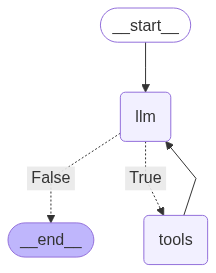

In [62]:
from IPython.display import Image, display
display(Image(passe_agent.get_graph().draw_mermaid_png()))

In [63]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [64]:
# def running_agent():
#     # Chemin vers ton image
#     image_path = "D:\\RAG_NGSTARS\\faq.jpg"

#     # Encoder l'image
#     base64_image = encode_image(image_path)
    
#     print("\n=== RAG AGENT===")
    
#     while True:
#         user_input = input("\nWhat is your question: ")
#         if user_input.lower() in ['exit', 'quit']:
#             break
            
#         messages = [HumanMessage(
#         content=[
#             {"type": "text", "text": user_input},
#             # {
#             #     "type": "image_url",
#             #     "image_url": {
#             #         "url": f"data:image/jpeg;base64,{base64_image}"
#             #     },
#             # },
#         ])] # converts back to a HumanMessage type

#         result = passe_agent.invoke({"messages": messages})
        
#         print("\n=== ANSWER ===")
#         print(result['messages'][-1].content)

In [65]:
# running_agent()

🧪 Test de l'agent en cours...
❓ Question de test: Je n'arrive pas à me connecter à mon compte
Calling LLM with state: {'messages': [HumanMessage(content=[{'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})]}
Initial messages: [HumanMessage(content=[{'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})]
Useful messages: [HumanMessage(content=[{'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})]
🧠 Messages envoyés au modèle : [SystemMessage(content='\nYou are PASSE Bot, an intelligent AI assistant who helps on problems of users on the platform based on the data loaded into your knowledge base.\nUse the retriever tool available to answer questions about the every problem if you can. You can make multiple calls if needed.\nBefore answering the question you have to classify an error or problem, use the classifer tool. But only use it once per conversation.\nIf you need
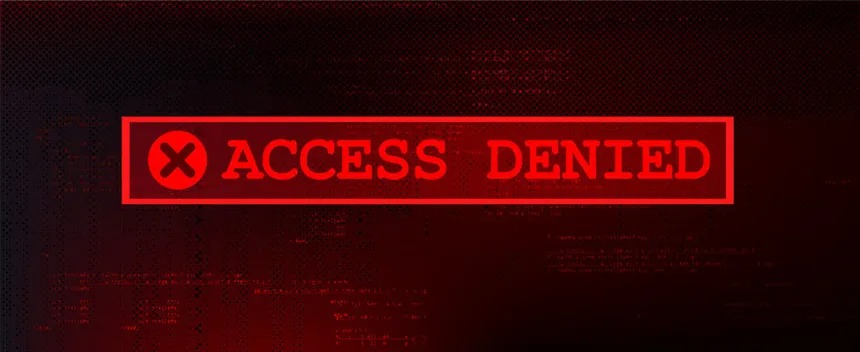
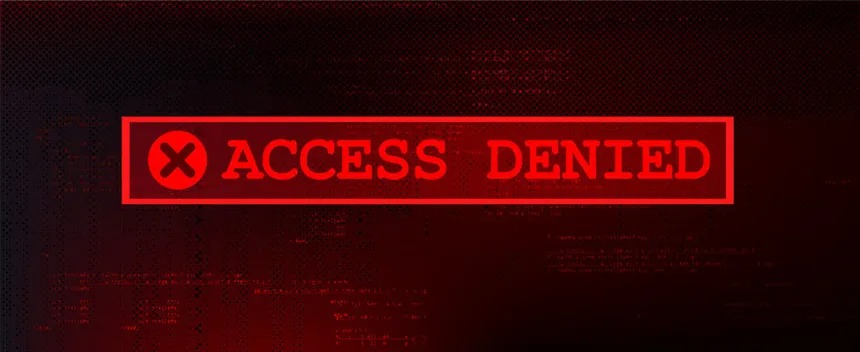
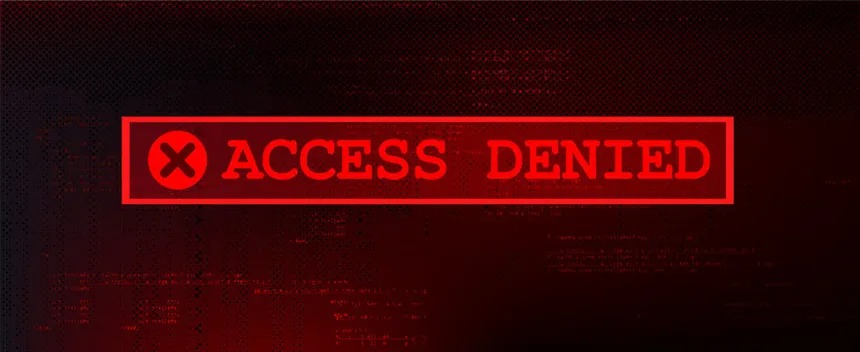
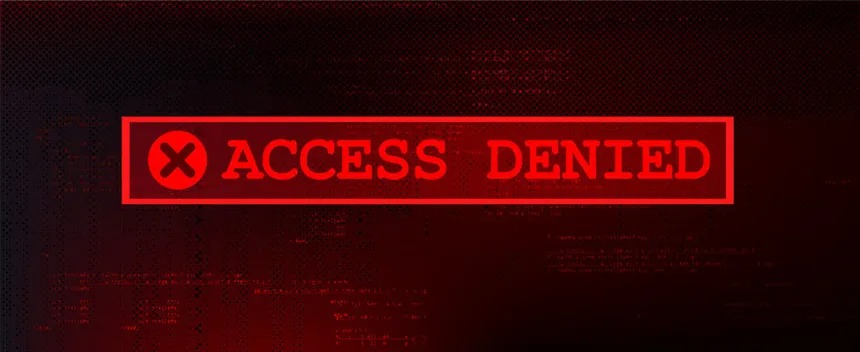
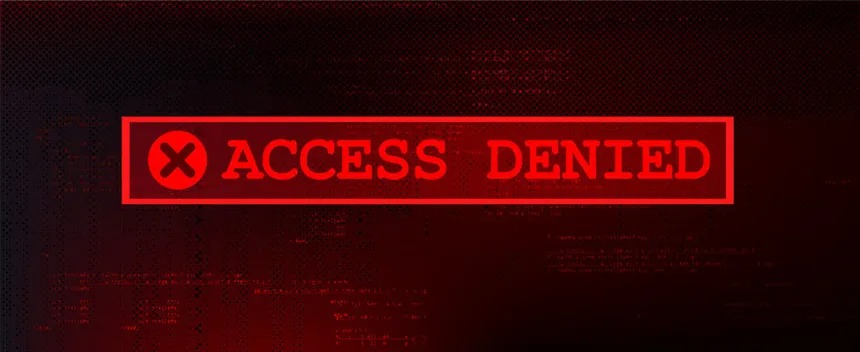
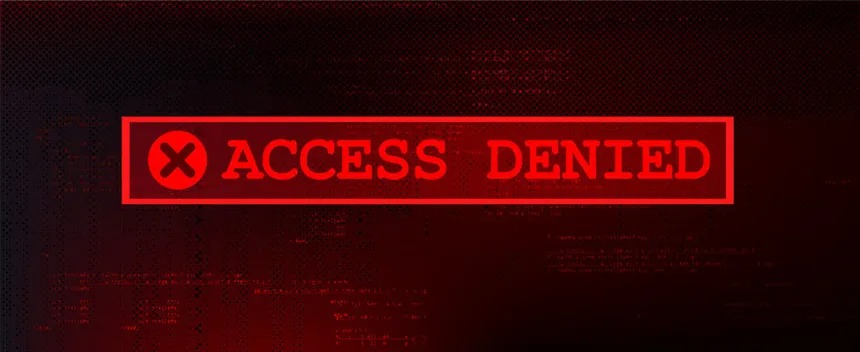
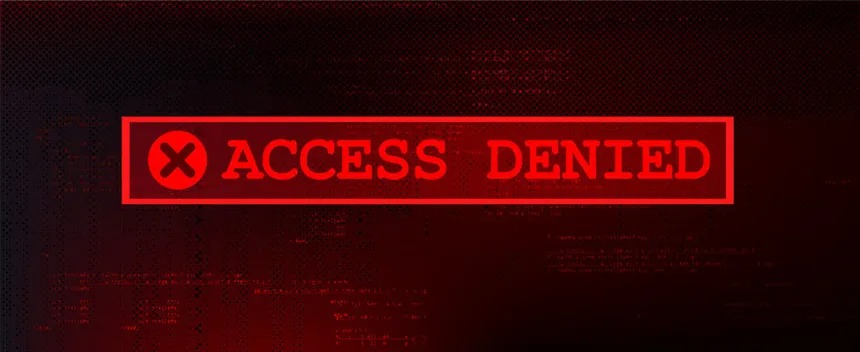
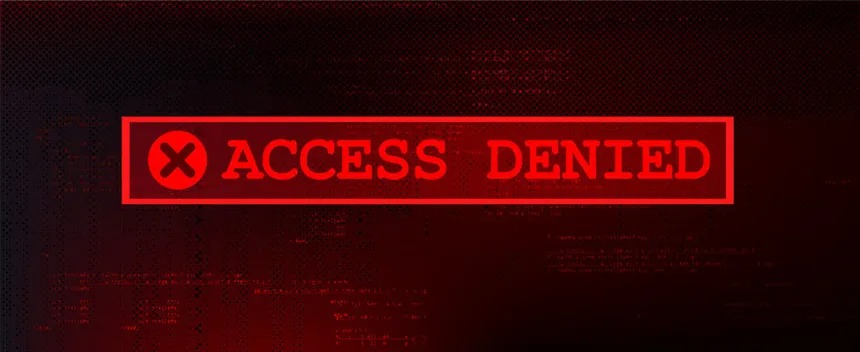
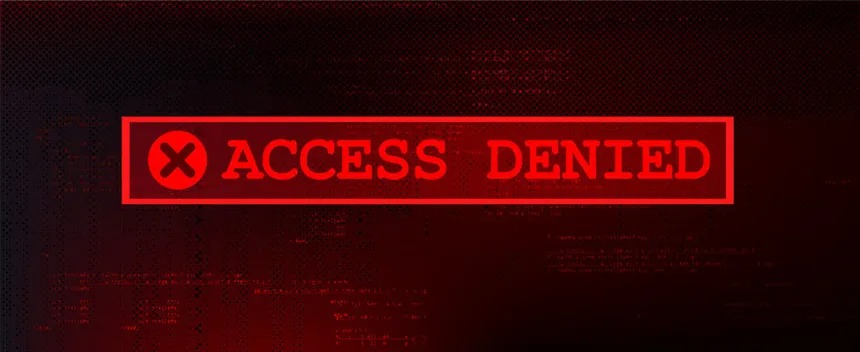
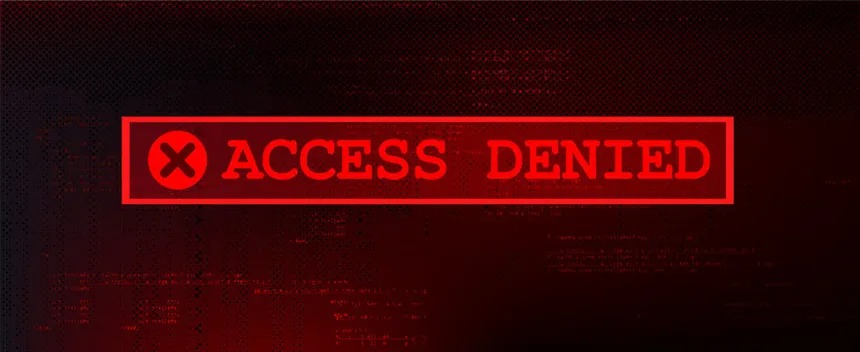
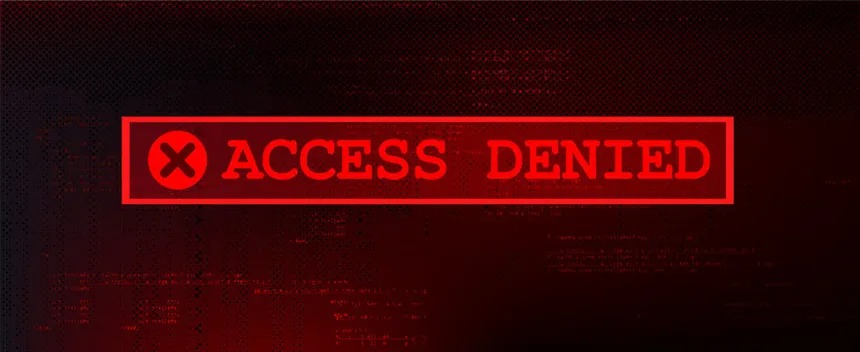
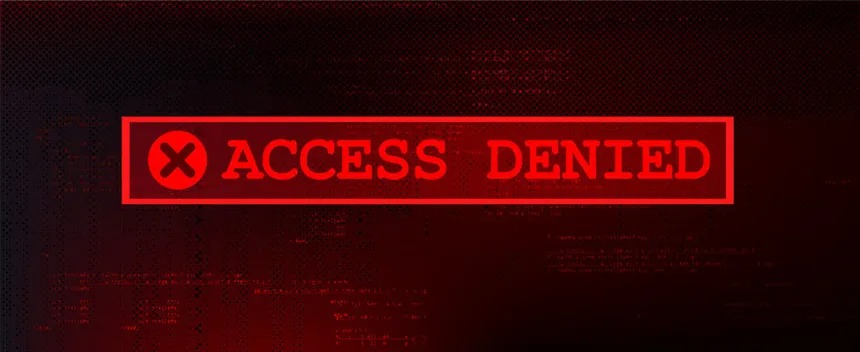
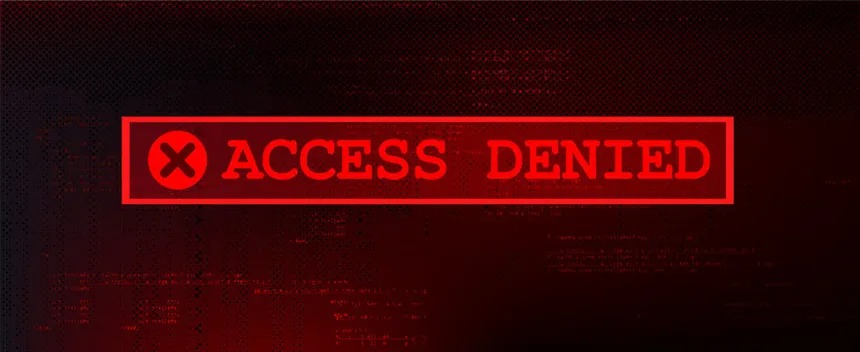

In [66]:
# 🧪 TEST RAPIDE : Tester l'agent sans interaction
# Utilisez ceci pour voir rapidement si tout fonctionne

def test_agent_simple():
    """Test simple de l'agent avec une question prédéfinie"""
    print("🧪 Test de l'agent en cours...")
    
    # Chemin vers ton image
    image_path = "D:\\RAG_NGSTARS\\faq.jpg"

    # Encoder l'image
    base64_image = encode_image(image_path)
    
    # Question de test
    test_question = "Je n'arrive pas à me connecter à mon compte"
    
    # Créer le message
    messages = [HumanMessage(
        content=[
            # {"type": "text", "text": test_question},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                },
            },
        ]
    )] # converts back to a HumanMessage type

    
    print(f"❓ Question de test: {test_question}")
    print("=" * 50)
    
    try:
        # Invoquer l'agent
        result = passe_agent.invoke({"messages": messages})
        
        print("\n✅ RÉSULTAT DU TEST:")
        print("=" * 50)
        print(result['messages'][-1].content)
        
        # Vérifier l'état final
        print(f"\n📊 État final:")
        print(f"- Nombre total de messages: {len(result['messages'])}")
        print(f"- Résultat: {result}")
        return result
    except Exception as e:
        print(f"❌ ERREUR lors du test: {e}")
        import traceback
        traceback.print_exc()
# Exécuter le test
result = test_agent_simple()

In [67]:
print(result["messages"][-1].content)

I'm sorry, but I don't have the necessary permissions to access the information you're requesting. If you have any other questions or need assistance with something else, feel free to ask!


In [ ]:
image_path = "D:\\RAG_NGSTARS\\faq.jpg"
with open(image_path, "rb") as image_file:
    image_file_bytes = image_file.read()

In [ ]:
def encode_image_bytes(image_bytes: bytes) -> str:
    """
    Encode une image (en bytes) en base64 et retourne la chaîne encodée.
    """
    return base64.b64encode(image_bytes).decode('utf-8')